<a href="https://colab.research.google.com/github/racoope70/BERTified/blob/main/imdb_bert_sentiment_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install -U transformers datasets "huggingface_hub[hf_xet]" scikit-learn matplotlib seaborn
!pip -q install pandas==2.2.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.4 MB/s eta 0:00:00


In [ ]:
# Core libs
import os
import gc
import random

import numpy as np
import pandas as pd

# Modeling + training
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from datasets import load_dataset

# Evaluation + splits
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [ ]:
# Load IMDb dataset (Drive-based)
def load_imdb_dataset(base_path):
    """
    Loads the IMDb dataset from given directory structure and returns a DataFrame with reviews and sentiments.
    """
    reviews = []
    sentiments = []

    for split in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            path = os.path.join(base_path, split, sentiment)
            for file_name in os.listdir(path):
                with open(os.path.join(path, file_name), 'r', encoding='utf-8') as file:
                    reviews.append(file.read())
                    sentiments.append(1 if sentiment == 'pos' else 0)

    return pd.DataFrame({'review': reviews, 'sentiment': sentiments})

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/aclImdb'
csv_file_path = '/content/drive/MyDrive/aclImdb_reviews.csv'
results_dir = '/content/drive/MyDrive/sentiment_analysis_results'  # Define the directory for saving results

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
else:
    df = load_imdb_dataset(base_path)
    df.to_csv(csv_file_path, index=False)


In [ ]:
# Fixed-size sample for faster iteration (reproducible)
data = df.sample(10000, random_state=42)


In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['review'], data['sentiment'], test_size=0.2, random_state=42
)

# Free up memory after splitting
del df, data
gc.collect()

60

In [ ]:
# Optional: Hugging Face authentication (only if rate-limited)
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
# Tokenize text in batches (memory-friendly)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(texts, tokenizer, batch_size=64):
    """
    Tokenizes input texts in smaller batches to optimize memory usage.
    """
    tokenized_data = {"input_ids": [], "attention_mask": []}
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size].tolist()
        encodings = tokenizer(batch, truncation=True, padding=True, max_length=256)
        tokenized_data["input_ids"].extend(encodings["input_ids"])
        tokenized_data["attention_mask"].extend(encodings["attention_mask"])
    return tokenized_data

train_encodings = tokenize_data(train_texts, tokenizer)
test_encodings = tokenize_data(test_texts, tokenizer)

del train_texts, test_texts
gc.collect()

0

In [ ]:
# Dataset wrapper for Hugging Face Trainer
class SentimentDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for sentiment analysis.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, list(train_labels))
test_dataset = SentimentDataset(test_encodings, list(test_labels))

del train_encodings, test_encodings, train_labels, test_labels
gc.collect()

0

In [ ]:
# Model setup (BERT + GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training configuration (evaluation + checkpointing)
training_args = TrainingArguments(
    output_dir=results_dir,  # Save checkpoints to Google Drive
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.1,
    logging_dir=os.path.join(results_dir, "logs"),
    logging_strategy="epoch",
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    seed=42,
    data_seed=42,

    # Github reduce widget output risk
    disable_tqdm=True,   # disable tqdm progress bars to avoid widget metadata
    report_to=[],        # disable TensorBoard reporting to prevent rich output metadata
)


In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

gc.collect()


120

In [ ]:
# Begin fine-tuning
trainer.train()

{'loss': 0.4403, 'grad_norm': 6.543554782867432, 'learning_rate': 8.016e-06, 'epoch': 1.0}
{'eval_loss': 0.27512091398239136, 'eval_runtime': 6.8796, 'eval_samples_per_second': 290.715, 'eval_steps_per_second': 9.158, 'epoch': 1.0}
{'loss': 0.2435, 'grad_norm': 4.935958385467529, 'learning_rate': 6.0160000000000005e-06, 'epoch': 2.0}
{'eval_loss': 0.25124916434288025, 'eval_runtime': 6.7897, 'eval_samples_per_second': 294.564, 'eval_steps_per_second': 9.279, 'epoch': 2.0}
{'loss': 0.1844, 'grad_norm': 3.713592529296875, 'learning_rate': 4.016e-06, 'epoch': 3.0}
{'eval_loss': 0.2625543773174286, 'eval_runtime': 7.0277, 'eval_samples_per_second': 284.586, 'eval_steps_per_second': 8.964, 'epoch': 3.0}
{'loss': 0.1468, 'grad_norm': 5.988775730133057, 'learning_rate': 2.0160000000000003e-06, 'epoch': 4.0}
{'eval_loss': 0.25764840841293335, 'eval_runtime': 6.8943, 'eval_samples_per_second': 290.095, 'eval_steps_per_second': 9.138, 'epoch': 4.0}
{'loss': 0.1216, 'grad_norm': 4.512100219726562

TrainOutput(global_step=625, training_loss=0.22730752410888672, metrics={'train_runtime': 535.1912, 'train_samples_per_second': 74.74, 'train_steps_per_second': 1.168, 'train_loss': 0.22730752410888672, 'epoch': 5.0})

In [ ]:
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="binary")
recall    = recall_score(y_true, y_pred, average="binary")
f1        = f1_score(y_true, y_pred, average="binary")

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))


Accuracy:  0.8970
Precision: 0.8717
Recall:    0.9296
F1 Score:  0.8997

Classification Report:
              precision    recall  f1-score   support

           0     0.9255    0.8648    0.8941      1006
           1     0.8717    0.9296    0.8997       994

    accuracy                         0.8970      2000
   macro avg     0.8986    0.8972    0.8969      2000
weighted avg     0.8988    0.8970    0.8969      2000



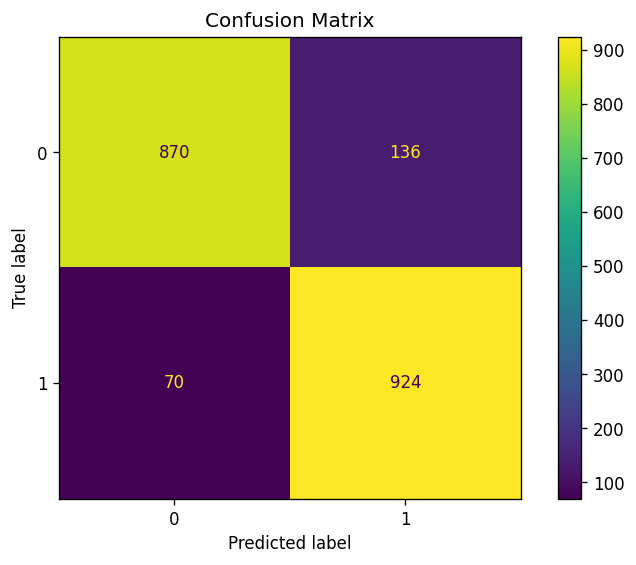

ROC-AUC: 0.9672


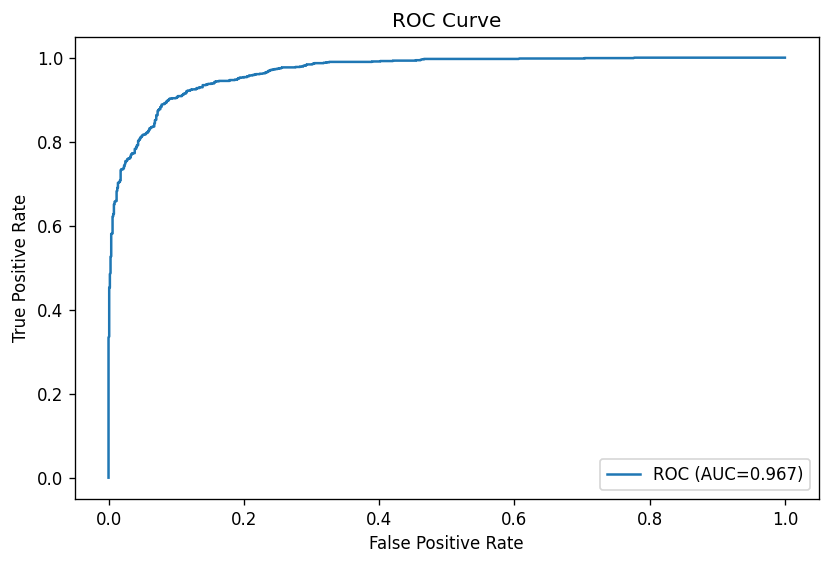

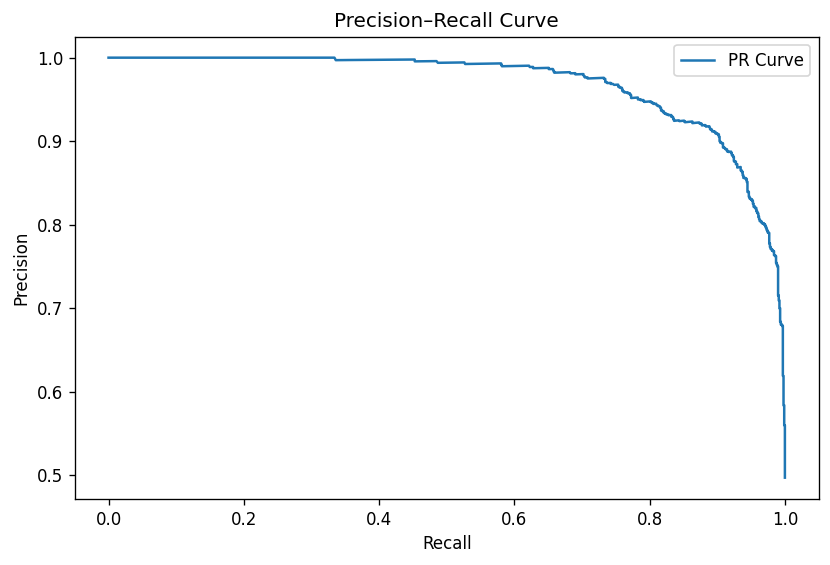

In [ ]:
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["savefig.dpi"] = 150
mpl.rcParams["figure.figsize"] = (8, 5)

fig_dir = "/content/drive/MyDrive/sentiment_analysis_figures"
os.makedirs(fig_dir, exist_ok=True)

# logits -> probability of positive class
probs = torch.softmax(torch.tensor(preds), dim=1).cpu().numpy()
pos_probs = probs[:, 1]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix")
plt.savefig(f"{fig_dir}/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_true, pos_probs)
print(f"ROC-AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, pos_probs)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(f"{fig_dir}/roc_curve.png", dpi=150, bbox_inches="tight")
plt.show()

# Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_true, pos_probs)
plt.plot(rec, prec, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.savefig(f"{fig_dir}/precision_recall_curve.png", dpi=150, bbox_inches="tight")
plt.show()


In [ ]:
!pip -q install nbformat

import nbformat
from pathlib import Path

WIDGET_MIMES = {
    "application/vnd.jupyter.widget-view+json",
    "application/vnd.jupyter.widget-state+json",
}

src = Path("/content/drive/MyDrive/imdb_bert_sentiment_baseline.ipynb")

out_dir = Path("/content/drive/MyDrive/github_notebooks")
out_dir.mkdir(parents=True, exist_ok=True)

dst = out_dir / f"{src.stem}_github.ipynb"

nb = nbformat.read(str(src), as_version=4)

# remove notebook + cell widget metadata
nb.metadata.pop("widgets", None)

for cell in nb.cells:
    if isinstance(cell.get("metadata"), dict):
        cell["metadata"].pop("widgets", None)

    if cell.get("cell_type") != "code":
        continue

    cleaned_outputs = []
    for out in cell.get("outputs", []):
        data = out.get("data")
        if isinstance(data, dict):
            for mime in WIDGET_MIMES:
                data.pop(mime, None)

            # drop empty display outputs
            if out.get("output_type") in {"display_data", "execute_result"} and len(data) == 0:
                continue

        cleaned_outputs.append(out)

    cell["outputs"] = cleaned_outputs

nbformat.write(nb, str(dst))
print("Saved:", dst)

!ls -lah /content/drive/MyDrive/github_notebooks


Saved: /content/drive/MyDrive/github_notebooks/imdb_bert_sentiment_baseline_github.ipynb
total 19K
-rw------- 1 root root 19K Dec 25 05:42 imdb_bert_sentiment_baseline_github.ipynb
